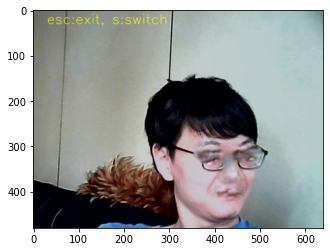

In [1]:
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy

import sys


offlineSwap = False
iFaceMod = 0

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)



font = cv2.FONT_HERSHEY_SIMPLEX
fntSize = 1
fntThickness = 1

def Draw_Text(img, sTxt, aX=30, aY=30):
    if ""==sTxt: return
    cv2.putText(img, str(sTxt) ,(aX,aY), font, 
        fntSize,(0,255,255), fntThickness,cv2.LINE_AA)
    
    
    
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        #print("Too Many Faces") #raise TooManyFaces
        return []
    if len(rects) == 0:
        #print("No Faces") #raise NoFaces
        return []

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

fn1 = "C:\\Users\\admin\\Desktop\\0707\\AFLW\\goal0606\\STYLEGAN\\GBB\\3\\48.png" #sys.argv[1]
fn2 = "C:\\Users\\admin\\Desktop\\0707\\AFLW\\goal0606\\STYLEGAN\\GBB\\3\\48.png"    #sys.argv[2]
fnOutput = "output_Camera.png" 

if offlineSwap:
    im1, landmarks1 = read_im_and_landmarks(fn1)
    im2, landmarks2 = read_im_and_landmarks(fn2)
    
    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                   landmarks2[ALIGN_POINTS])
    
    mask = get_face_mask(im2, landmarks2)
    warped_mask = warp_im(mask, M, im1.shape)
    combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                              axis=0)
    
    warped_im2 = warp_im(im2, M, im1.shape)
    warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)
    
    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask
    
    cv2.imwrite(fnOutput, output_im)

else:
    im2, landmarks2 = read_im_and_landmarks(fn2)
    mask = get_face_mask(im2, landmarks2)
    
    camera = cv2.VideoCapture(0)
    while True:
        return_value,im1 = camera.read()  
        
    #    imgInfo = np.asarray(image).shape     
    #    if len(imgInfo)<2: break
    #    imgH=imgInfo[0]
    #    imgW=imgInfo[1]
    #    imgChannel=imgInfo[2] 
        
        
        #cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        try:      
            if 0==iFaceMod:
                
                landmarks1 = get_landmarks(im1)
                
                if len(landmarks1)>1:

                    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                           landmarks2[ALIGN_POINTS])
                    
                    warped_mask = warp_im(mask, M, im1.shape)
                    combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                                              axis=0)
                    
                    warped_im2 = warp_im(im2, M, im1.shape)
                    warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)
                    
                    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask
                    
                    
                    #regular image for plt and cv2.imgshow()
                    output_im = (output_im-numpy.min(output_im)) / numpy.max(output_im) # normalize the data to 0 - 1
                    output_im = 255 * output_im # Now scale by 255
                    output_im = output_im.astype(numpy.uint8)

                    
#                    cv2.imwrite(fnOutput, output_im)            
#                    output_im = cv2.imread(fnOutput, cv2.IMREAD_COLOR)
#                    output_im = cv2.resize(output_im, (output_im.shape[1] * SCALE_FACTOR,
#                                         output_im.shape[0] * SCALE_FACTOR))
            
                    Draw_Text(output_im, "esc:exit, s:switch")
                    cv2.imshow('image',output_im)
                else:
                    Draw_Text(im1, "esc:exit, s:switch")
                    cv2.imshow('image',im1)
            elif 1==iFaceMod:
                Draw_Text(im1, "esc:exit, s:switch")
                cv2.imshow('image',im1)
            else:
                Draw_Text(im2, "esc:exit, s:switch")
                cv2.imshow('image',im2)
                
            
            
            key = cv2.waitKey(5) & 0xFF
            if key == 27:  #esc   ord('s'):
                plt.imshow( cv2.cvtColor(output_im,cv2.COLOR_BGR2RGB) )
                plt.show()
                #cv2.imwrite(fnOutput, output_im)
                break
            elif key == ord('s'):
                iFaceMod = (iFaceMod+1)%3
    #            cv2.imwrite("{}{}_{}.jpg".format(outputPath, outputFn, incId), image)
#                incId+=1
                
        except ValueError:
            break
    
    camera.release()
    cv2.destroyAllWindows()

In [ ]:
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.data.vision import ImageFolderDataset
from mxnet.gluon.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 
import mxnet.ndarray as nd
from mxnet.gluon import nn
from mxnet import autograd

def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
class Config():
    training_dir = "C:\\Users\\admin\\Desktop\\goal0606\\12\\own\\"
    testing_dir = "C:\\Users\\admin\\Desktop\\goal0606\\12\\owntest\\"
    train_batch_size = 90
    train_number_epochs = 100
    
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=True,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset)

        img0 = (img0_tuple[0]).asnumpy()
        img1 = (img1_tuple[0]).asnumpy()
        img0= Image.fromarray(img0)
        img1= Image.fromarray(img1)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img0 = np.asarray(img0,dtype=np.float32)
        img1 = np.asarray(img1,dtype=np.float32)
        img0 = img0.reshape((1, 112, 92))
        img1 = img1.reshape((1, 112, 92))
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform:
            img0 = mx.image.imresize(img0, 100, 100)
            img1 = mx.image.imresize(img1, 100, 100)
        return img0, img1 , nd.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)
    
    def __len__(self):
        return len(self.imageFolderDataset)
    
    
folder_dataset = ImageFolderDataset(root=Config.training_dir)   
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=False ,should_invert=False)

class SiameseNetwork(nn.Block):  
    def __init__(self, verbose=False,**kwargs):
        super(SiameseNetwork, self).__init__(**kwargs)
        self.verbose = verbose
        # add name_scope on the outer most Sequential
        with self.name_scope():
            # block 1
            b1 = nn.Sequential()
            b1.add(
                nn.Conv2D(4, kernel_size=3, padding=1, activation='relu'),
                nn.BatchNorm(),
                nn.Dropout(0.2)
            )
            
            b2 = nn.Sequential()
            b2.add(
                nn.Conv2D(8, kernel_size=3, padding=1, activation='relu'),
                nn.BatchNorm(),
                nn.Dropout(0.2)
            )
        
            b3 = nn.Sequential()
            b3.add(
                nn.Conv2D(8, kernel_size=3, padding=1, activation='relu'),
                nn.BatchNorm(),
                nn.Dropout(0.2)
            )
       
            b4 = nn.Sequential()
            b4.add(
                nn.Flatten(),
                nn.Dense(500, activation="relu"),
                nn.Dense(500, activation="relu"),
                nn.Dense(5)
            )
            self.net = nn.Sequential()
            self.net.add(b1, b2, b3, b4)
        

    def forward(self, input1, input2):
        output1 = self.net(input1)
        output2 = self.net(input2)
        return output1,output2
    
class ContrastiveLoss(nn.Block):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nd.sqrt(nd.sum(nd.power(nd.subtract(output1, output2),2))) 
        loss_contrastive = nd.mean(nd.add(nd.subtract(1,label) * nd.power(euclidean_distance, 2),(label) * nd.power(nd.subtract(self.margin, euclidean_distance), 2)))
        return loss_contrastive

train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8,batch_size=Config.train_batch_size)
from mxnet import init
net = SiameseNetwork()
criterion = ContrastiveLoss()
batch_size=Config.train_batch_size


ctx = mx.cpu(0)
counter = []
loss_history = [] 
iteration_number= 0

net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(),'sgd', {'learning_rate': 0.005, 'wd': 0.001})

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0 = img0.as_in_context(ctx)
        img1 = img1.as_in_context(ctx)
        label= label.as_in_context(ctx)
        with autograd.record():
            output1,output2 = net(img0, img1)
            loss_contrastive = criterion(output1,output2,label)   
        loss_contrastive.backward()        
        trainer.step(batch_size)
        if i %10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.asnumpy()[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.asnumpy()[0])
show_plot(counter,loss_history) 

In [52]:
from PIL import Image

for i in range(0,330,1) :

    img = Image.open("C:\\Users\\admin\\Desktop\\goal0606\\STYLEGAN\\recognition\\recognition\\"+str(i+1)+".png")
    print(img.size)
#img.show()

    new_img = img.crop((283.6,0,567.2,276))  # (left, upper, right, lower)
#new_img.show()
    new_img.save("C:\\Users\\admin\\Desktop\\goal0606\\STYLEGAN\\recognition\\2\\"+str(i+1)+".png")

(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)
(851, 276)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\admin\\Desktop\\goal0606\\STYLEGAN\\recognition\\recognition\\301.png'

In [ ]:
import os
import cv2
import numpy as np

#img =['0train256original1.png']
#img01 = ['landmarks0.png']

path = 'C:\\Users\\admin\\Desktop\\0606\\ll\\'
path2= 'C:\\Users\\admin\\Desktop\\0606\\girl256\\'

for i in range(269,790,1) :

    img2 = cv2.imread(path +str(i)+'.jpg')
    img1 = cv2.imread(path2 +str(i)+'.jpg')
    vis = np.concatenate((img1, img2), axis=1)
    cv2.imwrite('C:\\Users\\admin\\Desktop\\0606\\girlL256\\'+str(i-6)+'.jpg',vis)

In [21]:
import cv2

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # color to gray
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 顯示圖片
    cv2.imshow('frame', frame)
    # 按下 q 鍵離開迴圈
    if cv2.waitKey(1) == ord('q'):
        break

# 釋放該攝影機裝置
cap.release()
cv2.destroyAllWindows()